In [1]:
import keras
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.layers import *
import pandas as pd
import numpy as np
from position import Position
import matplotlib.pyplot as plt
%matplotlib inline
import imp
# imp.reload(cnnfeat)
from multiprocessing import Queue
from multiprocessing import Manager, Process, Pool
import os
from time import time
import pickle
import bcolz
from tqdm import tqdm 
from cnnfeat import get_feats

Using TensorFlow backend.


Initializing Magics


In [2]:
from cycliclr import CyclicLR
from math import ceil

In [28]:
def dense_model():
    net_input = Input((8,8,14))
    x = Flatten()(net_input)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    output = Activation('tanh')(x)
    # 13997 params
    return net_input, output

In [29]:
inputs, output = dense_model()
model = Model(inputs, output)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 8, 14)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               114816    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
__________

In [6]:
def batch_generator_df_bcolz(dframe, bcolz_arr, batch_size, shuffle=True, yielder=lambda x: x):
    assert(batch_size % bcolz_arr.chunklen == 0)
    chunks_per_batch = batch_size // bcolz_arr.chunklen
    init_bounds = bcolz_arr.partitions
    if bcolz_arr.leftover_elements > 0:
        init_bounds.append((init_bounds[-1][1], len(bcolz_arr)))
    while True:
        bounds = np.random.permutation(init_bounds) if shuffle else init_bounds
        feats_chunks, scores_chunks = [], []
        def return_batch():
            feats = np.concatenate(feats_chunks, axis=0)
            scores = np.concatenate(scores_chunks, axis=0)
            feats_chunks.clear()
            scores_chunks.clear()
            return yielder((feats, scores))
        chunks = 0
        for start, stop in bounds:
            feats_chunks.append(bcolz_arr[start:stop])
            scores_chunks.append(np.array(dframe[start:stop].score, dtype='float32'))
            chunks += 1
            if chunks % chunks_per_batch == 0:
                yield return_batch()
        if len(feats_chunks) > 0:
            yield return_batch()

In [7]:
from bcolz_array_iterator import BcolzArrayIterator

def batch_generator_bcolz(data, batch_size, shuffle=True):
    batch_generator_bcolz = BcolzArrayIterator(data, batch_size=batch_size, shuffle=shuffle)
    while True:
        feats = next(batch_generator_bcolz)
        yield feats, feats

In [8]:
def batch_generator_df(data, batch_size, shuffle=True):
    while True:
        data_ = data.sample(frac=1) if shuffle else data
        for iteration, batch in data_.groupby(np.arange(len(data)) // batch_size):
            fens = [f.strip() for f in batch.fen.tolist()]
            feats = np.stack([get_feats(Position.from_fen(fen)) for fen in fens])
            yield feats, feats

In [9]:
model.compile(keras.optimizers.SGD(lr=.01, momentum=.99, nesterov=True), 'mse')

In [30]:
model.compile('adam', 'mse')

In [31]:
features_sf3_sample = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_sample.bc')
features_sf3_valid_sample = bcolz.open(mode='r', rootdir='/ssd/slonik_data/features_sf3_valid_sample.bc')

In [32]:
sf_scores3 = pd.read_pickle('/ssd/slonik_data/sf_scores_3dep.pkl')

In [33]:
assert(np.allclose(features_sf3_valid_sample[0], get_feats(Position.from_fen(sf_scores3.iloc[-60000].fen))))
assert(np.allclose(features_sf3_sample[0], get_feats(Position.from_fen(sf_scores3.iloc[0].fen))))

In [34]:
wgts = model.get_weights()

In [62]:
model.set_weights(wgts)

In [40]:
batch_size = 1024
#nvalid = len(features_sf12_valid)

x = features_sf3_sample
x_valid = features_sf3_valid_sample

# yielder = lambda f_s: (f_s[0], [f_s[0], f_s[1]]) # (feats, [feats, scores])
train_gen = batch_generator_df_bcolz(sf_scores3, x, batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores3[-60000:], x_valid, batch_size, shuffle=False)

train_steps = ceil(len(x) / batch_size)
valid_steps = ceil(len(x_valid) / batch_size)

# lr_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1)
# checkpoint_path = '../slonik_data/weights.{epoch:03d}-{val_loss:.6f}.h5'
checkpoint_path = '../slonik_data/weights_best.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             monitor='val_loss', save_best_only=True, save_weights_only=True, period=1)
# stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='auto')
clr = CyclicLR(base_lr=1e-6, max_lr=1e-3, step_size=train_steps*5, mode='triangular')
# clr = CyclicLR(base_lr=0, max_lr=1e-2, step_size=train_steps*5, mode='triangular')

# callbacks = [clr]
callbacks = [clr, checkpoint]
# K.set_value(train_model.optimizer.lr, 1e-3)
model.fit_generator(train_gen, train_steps, epochs=100, 
                          validation_data=valid_gen, validation_steps=valid_steps, callbacks=callbacks)

# K.set_value(model.optimizer.lr, 1e-5)
# model.fit_generator(train_gen, train_steps, epochs=2, validation_data=valid_gen, validation_steps=valid_steps)

Epoch 1/100
24/24 [==============================] - 0s 12ms/step - loss: 1.3231e-04 - val_loss: 0.0026
Epoch 2/100
24/24 [==============================] - 0s 11ms/step - loss: 1.2524e-04 - val_loss: 0.0026
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 1.2421e-04 - val_loss: 0.0027
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 1.3241e-04 - val_loss: 0.0026
Epoch 5/100
24/24 [==============================] - 0s 11ms/step - loss: 1.7031e-04 - val_loss: 0.0027
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 3.5659e-04 - val_loss: 0.0033
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 8/100
24/24 [==============================] - 0s 11ms/step - loss: 8.8013e-04 - val_loss: 0.0028
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 5.1151e-04 - val_loss: 0.0028
Epoch 10/100
24/24 [==============================] - 0s 10ms/step -

Epoch 79/100
24/24 [==============================] - 0s 10ms/step - loss: 1.5127e-04 - val_loss: 0.0026
Epoch 80/100
24/24 [==============================] - 0s 11ms/step - loss: 5.8113e-05 - val_loss: 0.0026
Epoch 81/100
24/24 [==============================] - 0s 11ms/step - loss: 5.1320e-05 - val_loss: 0.0026
Epoch 82/100
24/24 [==============================] - 0s 10ms/step - loss: 4.5212e-05 - val_loss: 0.0026
Epoch 83/100
24/24 [==============================] - 0s 11ms/step - loss: 5.0274e-05 - val_loss: 0.0026
Epoch 84/100
24/24 [==============================] - 0s 10ms/step - loss: 9.8683e-05 - val_loss: 0.0026
Epoch 85/100
24/24 [==============================] - 0s 10ms/step - loss: 1.9247e-04 - val_loss: 0.0042
Epoch 86/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 87/100
24/24 [==============================] - 0s 11ms/step - loss: 5.6834e-04 - val_loss: 0.0026
Epoch 88/100
24/24 [==============================] - 0s 11

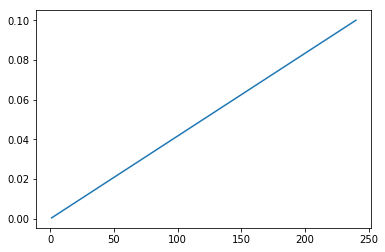

In [46]:
plt.plot(clr.history['iterations'], clr.history['lr'])

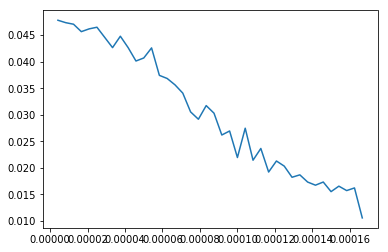

In [21]:
# rng = np.s_[-140:]
plt.plot(clr.history['lr'][rng], clr.history['loss'][rng])

### evaluate models

In [24]:
batch_size = 1024 * 2
valid_steps = ceil(len(features_sf3_valid_sample) / batch_size)
valid_gen = batch_generator_df_bcolz(sf_scores3[-60000:], features_sf3_valid_sample, batch_size, shuffle=False)
model.evaluate_generator(valid_gen, steps=valid_steps)
# train_model.metrics_names
# K.get_value(train_model.optimizer.lr)

0.0054805014319717887

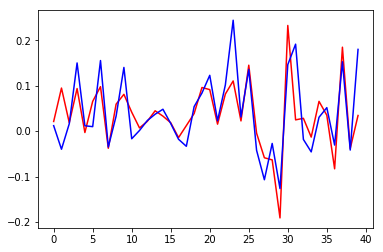

In [41]:
rng = slice(0,40)
dfrng = slice(rng.start+-60000, rng.stop+-60000)
fens = sf_scores3[dfrng].fen
scores = sf_scores3[dfrng].score
# np.allclose(features_sf12_valid[rng], np.array([get_feats(Position.from_fen(f)) for f in fens]))
# pprint(list(zip(scores, evaluator.predict(features_sf12_valid[rng]).squeeze())))
x = np.arange(len(scores))
plt.plot(x, scores, 'r')
plt.plot(x, model.predict(features_sf3_valid_sample[rng]).squeeze(), 'b')

In [19]:
model.predict(features_sf3_valid_sample[rng]).shape

(40, 8, 8, 1)

In [85]:
n = 28
print(Position.from_fen(sf_scores3.iloc[-60000+n].fen))
print(sf_scores3.iloc[-60000+n].score)
model.predict(features_sf3_valid_sample[n][None])

W to move
 ·  ·  ·  ·  ·  ·  ♚  · 
 ·  ·  ·  ·  ·  ♟  ·  ♟ 
 ·  ·  ♟  ·  ♙  ·  ·  · 
 ·  ·  ·  ♞  ·  ·  ·  · 
 ·  ·  ·  ♕  ·  ♙  ·  · 
 ·  ·  ·  ·  ·  ♙  ·  ♙ 
 ♙  ·  ·  ·  ·  ·  ·  ♔ 
 ·  ·  ·  ♝  ♛  ·  ·  · 

-0.0633715525256


array([[-0.00351094]], dtype=float32)